# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75.

# Оглавление

1. [Подготовка](#Подготовка)
2. [Изучение данных](#Изучение-данных)
3. [Обучение моделей](#Обучение-моделей)
4. [Выводы](#Выводы)
5. [Обучение с BERT](#Обучение-с-BERT)

## Подготовка

In [1]:
!pip install ppb

In [2]:
!pip install catboost

In [3]:
!pip install transformers

In [4]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import spacy
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import transformers as ppb
from tqdm import notebook
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

## Изучение данных

Прочитаем данные из файла, сохраним их в *data* и посмотрим на них.

In [5]:
data = pd.read_csv('/content/toxic_comments.csv') 
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Перед нами размеченный датасет с сообщениями в первом столбце и определением позитивный или негативный комментарий во втором.

Взглянем на долю негативных комментариев.

In [6]:
data['toxic'].mean()

0.10167887648758234

Мы имеем 10% негативных комментариев и 90% позитивных.

Проверим, есть ли в данных дубликаты.

In [7]:
data.duplicated().sum()

0

In [8]:
data.shape

(159571, 2)

Дубликатов не найдено. 

Поскольку данных слишком много, сократим их, взяв сто тысяч твитов.

In [9]:
data = data.sample(n=100000, random_state=42).reset_index(drop=True)

Проверим соотношение меток в целевом признаке после того, как убрали часть данных.

In [10]:
data['toxic'].mean()

0.1012

Соотношение в 10% сохраняется.

Посмотрим на первое сообщение.

In [11]:
 data['text'][0]

"Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?"

Помимо текста на английском в сообщениях также встречаются и цифры.

С данными всё в порядке. Подготовим данные для моделей. Первым делом проведём лемматизацию объектов. Для этого сначала инициализируем модель **spacy** с английским языком, необходимую для лемматизации. 

In [12]:
nlp = spacy.load('en_core_web_sm')

Лемматизируем текст и сохраним его в новую колонку, чтобы не потерять.

In [13]:
data['new_text'] = data['text'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

Взглянем на первые объект датасета после лемматизации.

In [14]:
data['new_text']

0        Geez , be -PRON- forgetful !   -PRON- have alr...
1        Carioca rfa \n\n thank for -PRON- support on -...
2        " \n\n  birthday \n\n no worry , -PRON- be wha...
3        pseudoscience category ? \n\n -PRON- be assume...
4        ( and if such phrase exist , -PRON- would be p...
                               ...                        
99995    Absolute Nonsense \n this article be nothing b...
99996    please reactivate user name \n\n greeting , \n...
99997                  what \n\n why do -PRON- do that ! !
99998    so -PRON- would be too difficult for -PRON- to...
99999    " \n\n just a clarification : some form of rel...
Name: new_text, Length: 100000, dtype: object

Мы видим, что слова приведены к словарной форме вполне корректно. Так *`are you`* превратилась в *`be -PRON-`*. Также у нас остались все знаки препинания и цифры, которые ничего не могут сказать о тональности комментариев, поэтому мы почистим тексты удалив эти объекты.

In [15]:
data['clear'] = data['new_text'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z ]', ' ', x).split()))

Взглянем на результат чистки на примере первого сообщения.

In [16]:
data['clear']

0        Geez be PRON forgetful PRON have already discu...
1        Carioca rfa thank for PRON support on PRON req...
2        birthday no worry PRON be what PRON do enjoy u...
3        pseudoscience category PRON be assume that thi...
4        and if such phrase exist PRON would be provide...
                               ...                        
99995    Absolute Nonsense this article be nothing but ...
99996    please reactivate user name greeting PRON be a...
99997                             what why do PRON do that
99998    so PRON would be too difficult for PRON to wri...
99999    just a clarification some form of religion be ...
Name: clear, Length: 100000, dtype: object

Теперь мы можем удалить промежуточный столбец из таблицы.

In [17]:
data = data.drop(['new_text'], axis=1)

In [18]:
data.head()

,text,toxic,clear
0,"Geez, are you forgetful! We've already discus...",0,Geez be PRON forgetful PRON have already discu...
1,Carioca RFA \n\nThanks for your support on my ...,0,Carioca rfa thank for PRON support on PRON req...
2,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,birthday no worry PRON be what PRON do enjoy u...
3,Pseudoscience category? \n\nI'm assuming that ...,0,pseudoscience category PRON be assume that thi...
4,"(and if such phrase exists, it would be provid...",0,and if such phrase exist PRON would be provide...


Взглянем, есть ли пропущенные значения в обновлённой таблице.

In [19]:
data.isna().sum()

text     0
toxic    0
clear    0
dtype: int64

Пропусков не обнаружено.

После подготовки текста, можем переходить к разделению нашей выборки на признаки и целевой признак. Признаком у нас будет служить подготовленный очищенный текст, а целевым признаком - *toxic*.

In [20]:
features = data.drop(['text', 'toxic'], axis=1)
target = data['toxic']

Теперь поделим выборку на обучающую и тестовую, выделив для тесторования 25% всех данных.

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=42)

Взглянем на размер выборок.

In [22]:
features_train.shape,  features_test.shape

((75000, 1), (25000, 1))

У нас получилось почти 75 тысяч объектов для обучения и 25 тысяч для проверки. Проверим долю негативных комментариев на обучении и тесте.

In [23]:
target_train.mean(), target_test.mean()

(0.101, 0.1018)

Доля в 10% сохраняется на обеих выборках.

Определим корпуса для трейна и теста на которых будем обучать и трансформировать наши тексты, определяя частоту слов.

In [24]:
corpus_train = features_train['clear'].values.astype('U')

In [25]:
corpus_test = features_test['clear'].values.astype('U')

Теперь определим векторизатор, указав ему стоп-слова.

In [26]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Наконец обучим и трансформируем тексты, определив две выборки, по которым мы и будем непосредственно обучать модели.

In [27]:
tf_idf = count_tf_idf.fit_transform(corpus_train)

In [28]:
tf_idf_test = count_tf_idf.transform(corpus_test)

Посмотрим на размер полученных признаков.

In [29]:
tf_idf.shape, tf_idf_test.shape

((75000, 100225), (25000, 100225))

Теперь количество признаков увеличилось с одного до 100 тысяч.

## Обучение моделей

Пришло время обучать модели и предсказывать целевой признак. Начнём с *логистической регрессии*. Поскольку у нас выборка не сбалансирована, укажем параметр *`class weight - balanced`*.

In [30]:
model_lr = LogisticRegression(random_state=42, class_weight='balanced')

Обучим модель указав в качестве призаков переменную *tf_idf*.

In [31]:
model_lr.fit(tf_idf, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Выполним предсказание на обучающей выборке и посчитаем f1, как меру качества модели.

In [32]:
pred_lr = model_lr.predict(tf_idf)

In [33]:
f1_lr = f1_score(target_train, pred_lr)
f1_lr

0.8367637835680484

*Логистическая регрессия* показала хороший результат - 84%.

Теперь определим и обучим модель *дерева решений*.

In [34]:
model_dtc = DecisionTreeClassifier(max_depth=100, random_state=42, min_samples_leaf=5, class_weight='balanced')

In [35]:
model_dtc.fit(tf_idf, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Теперь предскажем и подсчитаем f1 для *дерева*.

In [36]:
pred_dtc = model_dtc.predict(tf_idf)

In [37]:
f1_dtc = f1_score(target_train, pred_dtc)
f1_dtc

0.7521564749189605

Эта модель справилась чуть хуже предыдущей, её качество предсказаний составило 75%.

Теперь возьмём модель *случайного леса*.

In [38]:
model_rfc = RandomForestClassifier(max_depth=100, random_state=42, min_samples_leaf=5, n_estimators=100, class_weight='balanced')

In [39]:
model_rfc.fit(tf_idf, target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
pred_rfc = model_rfc.predict(tf_idf)

In [41]:
f1_rfc = f1_score(target_train, pred_rfc)
f1_rfc

0.5955001547098085

*Случайный лес* показал худший результат - 59%.

Возьмём модель *CatBoost*. У этой модели есть встроенный инструмент обработки текстовых признаков, поэтому в качестве признака, на котором модель будет обучаться выберем лемматизированный текст, указав его как текстовый признак.

In [42]:
text_features = ['clear']

Обучать будем, указав в качестве параметров *learning rate* 1 и метрику качества F1.

In [43]:
model_cb = CatBoostClassifier(random_state=42, verbose=100, learning_rate=1, eval_metric='F1')

In [44]:
model_cb.fit(features_train, target_train, text_features=text_features)

0:	learn: 0.6775636	total: 353ms	remaining: 5m 52s
100:	learn: 0.8326168	total: 30.2s	remaining: 4m 28s
200:	learn: 0.8771930	total: 59s	remaining: 3m 54s
300:	learn: 0.9073394	total: 1m 27s	remaining: 3m 23s
400:	learn: 0.9297801	total: 1m 56s	remaining: 2m 54s
500:	learn: 0.9468966	total: 2m 26s	remaining: 2m 25s
600:	learn: 0.9604047	total: 2m 55s	remaining: 1m 56s
700:	learn: 0.9693466	total: 3m 24s	remaining: 1m 27s
800:	learn: 0.9753582	total: 3m 53s	remaining: 57.9s
900:	learn: 0.9802324	total: 4m 21s	remaining: 28.8s
999:	learn: 0.9838753	total: 4m 49s	remaining: 0us


Предскажем целевой признак и посмотрим на точность модели.

In [45]:
pred_cb = model_cb.predict(features_train)

In [46]:
f1_cb = f1_score(target_train, pred_cb)
f1_cb

0.9596811690468283

*CatBoost* выдал точность в 95%.

Сравним полученные результаты.

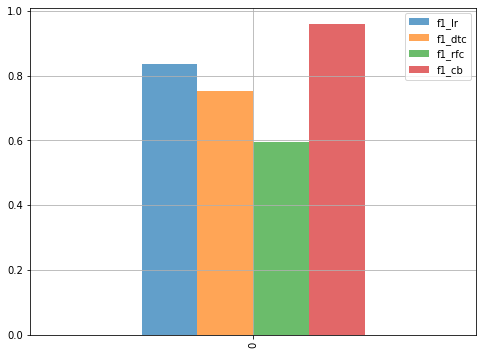

In [47]:
f1_all = pd.DataFrame({'f1_lr': [f1_lr],
                         'f1_dtc': [f1_dtc],
                         'f1_rfc': [f1_rfc],
                         'f1_cb': [f1_cb]
                        })
f1_all.plot(kind='bar', grid=True, figsize=(8,6), alpha=0.7);

Из всех моделей наилучшая точность предсказаний оказалась у *CatBoost* - 95%. Второй результат по точности оказался у *логистической регрессии*, её F1-мера составила 84%. Далее расположилась модель *дерева решений*, её точность составила 75%. Модель *случайного леса* хуже всех определяет тональность текстов, её точность 59%.

Теперь проверим, как хорошо предсказывают наши модели на тестовых данных. Напомню, что нам нужно достичь точность в 75%. Начнём с *логистической регрессии*.

In [48]:
predicted_lr = model_lr.predict(tf_idf_test)
f1_lr_test = f1_score(target_test, predicted_lr)
f1_lr_test

0.738809809638141

Точность *логистической регрессии* на тесте равна 74%. Посмотрим на матрицу ошибок предсказаний данной модели.

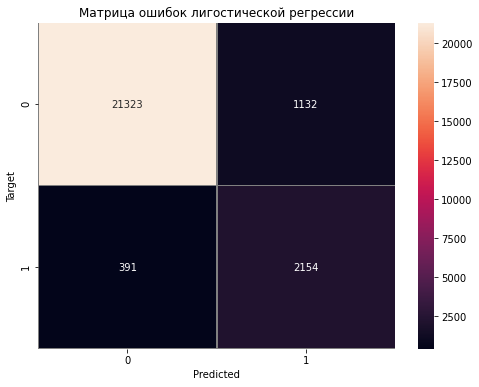

In [49]:
conf_matr_lr = confusion_matrix(target_test, predicted_lr)
plt.figure(figsize=(8,6))
sn.heatmap(conf_matr_lr, linecolor='grey', linewidths=.5, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Матрица ошибок лигостической регрессии')
plt.show()

Общее число правильно предсказанных результатов равно 23,5 тыс. Ошиблась модель в 1523 случаях. Больше всего ошибок в определении позитивных комментариев - 1132. Однако, если учесть, что негативных было всего 10% от общего числа и общее их число около 2,5 тысяч, то процент правильно предсказанных токсичных комментариев - 94%.

Теперь предскажем целевой признак и посчитаем точность этих предсказаний модели *дерева решений*.

In [50]:
predicted_dtc = model_dtc.predict(tf_idf_test)
f1_dtc_test = f1_score(target_test, predicted_dtc)
f1_dtc_test

0.5993844160051839

Её точность составила 60%, и эта модель не справилась с поставленной задачей. Посмотрим на её матрицу ошибок.

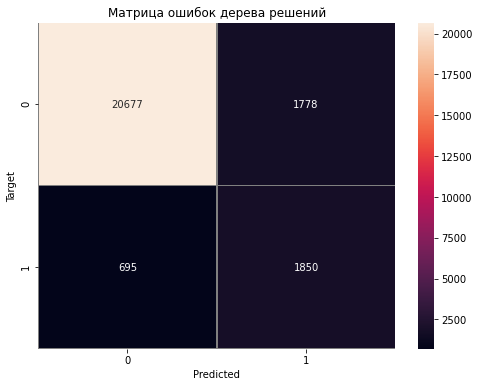

In [51]:
conf_matr_dtc = confusion_matrix(target_test, predicted_dtc)
plt.figure(figsize=(8,6))
sn.heatmap(conf_matr_dtc, linecolor='grey', linewidths=.5, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Матрица ошибок дерева решений')
plt.show()

Как мы видим точность как негативных, так и позитивных комментариев здесь заметно хуже предыдущей модели. Общее количество ошибок составляет 2473. Среди негативных комментариев правильно предсказано лишь 2/3 из всех. Чуть больше половины всех негативно размеченных моделью сообщений оказались правильно размеченными.

Взгялнем на модель *случайного леса*

In [52]:
predicted_rfc = model_rfc.predict(tf_idf_test)
f1_rfc_test = f1_score(target_test, predicted_rfc)
f1_rfc_test

0.5465409640154031

Её точность оказалась ещё хуже предыдущей модели - всего 55%.

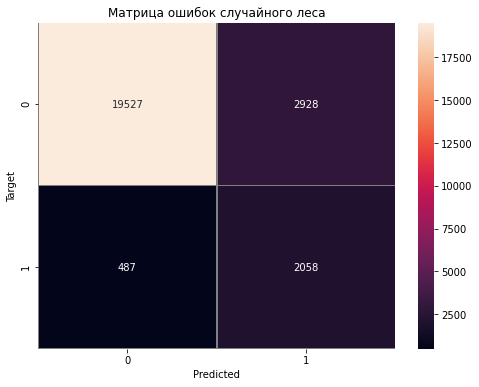

In [53]:
conf_matr_rfc = confusion_matrix(target_test, predicted_rfc)
plt.figure(figsize=(8,6))
sn.heatmap(conf_matr_rfc, linecolor='grey', linewidths=.5, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Матрица ошибок случайного леса')
plt.show()

Согласно матрице ошибок, общее числол ошибок равно 3406 случаям. Большая часть из этих ошибок это неправильно размеченные позитивные комментарии. Из всех, предсказанных как негативные, модель ошиблась в 59% случаев, это очень много.

Посмотрим на результаты последней модели.

In [54]:
predicted_cb = model_cb.predict(features_test)
f1_cb_test = f1_score(target_test, predicted_cb)
f1_cb_test

0.7640308783642813

Единственная модель, которая справилась с задачей, выдав точность в 76%.

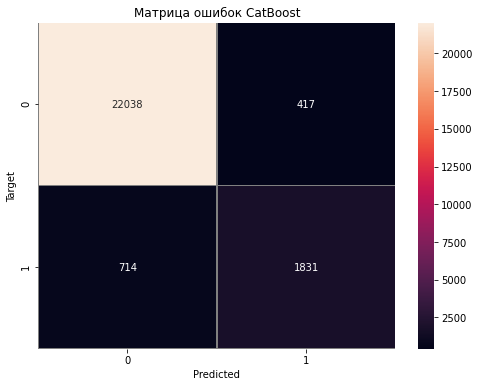

In [55]:
conf_matr_cb = confusion_matrix(target_test, predicted_cb)
plt.figure(figsize=(8,6))
sn.heatmap(conf_matr_cb, linecolor='grey', linewidths=.5, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Матрица ошибок CatBoost')
plt.show()

Однако и *CatBoost* не идеален, он совершил 1131 ошибку в предсказаниях. Правда в отличие от остальных моделей, данная модель хуже всех справилась с предсказанием негативных комментариев, их количество - 714, *CatBoost* их посчитал за позитивные.

## Выводы

Сравним все показатели на одном графике.

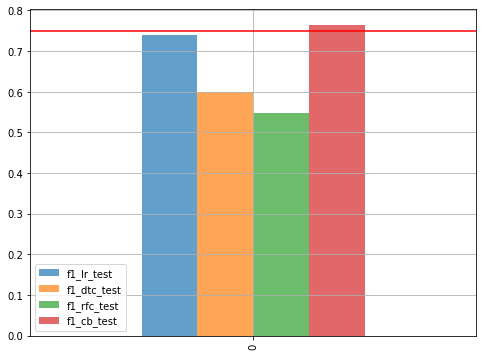

In [56]:
f1_final = pd.DataFrame({'f1_lr_test': [f1_lr_test],
                         'f1_dtc_test': [f1_dtc_test],
                         'f1_rfc_test': [f1_rfc_test],
                         'f1_cb_test': [f1_cb_test]
                        })
f1_final.plot(kind='bar', grid=True, figsize=(8,6), alpha=0.7);
plt.axhline(y=0.75, color='r', linestyle='-')
plt.show()

Не смотря на то, что для классических моделей мы использовали преобразования, увеличивающие количество признаков, лучшей по определению негативных комментариев оказалась бустинговая модель *CatBoost*, имеющая внутри себя собственный инструмент работы с текстовыми признаками. Её точность составила 76%. Справилась с поставленной задачей и модель *логистической регрессии*, которая чуть-чуть не достигла 75% точности предсказаний. Модель *дерева решений* и *случайного леса* не справились с задачей, а последняя и вовсе показала результат в чуть более 50%.

# Обучение с BERT

Теперь сравним, как справляется `BERT` в связке с моделью машинного обучения с поиском негативных комментариев.

In [57]:
cuda0 = torch.device('cuda')
cuda0

device(type='cuda')

Для начала определим модель и токенайзер ждя обработки текста.

In [58]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Разобъём все наши твиты на токены. Будем использовать уже очищенные данные. Определим максимальную длину строки в 256 объектов.

In [59]:
tokenized = data['clear'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256))
tokenized

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0        [101, 20277, 2480, 2022, 4013, 2078, 5293, 399...
1        [101, 2482, 3695, 3540, 21792, 2050, 4067, 200...
2        [101, 5798, 2053, 4737, 4013, 2078, 2022, 2054...
3        [101, 18404, 11020, 13684, 4696, 4013, 2078, 2...
4        [101, 1998, 2065, 2107, 7655, 4839, 4013, 2078...
                               ...                        
99995    [101, 7619, 14652, 2023, 3720, 2022, 2498, 202...
99996    [101, 3531, 10509, 21466, 5310, 2171, 14806, 4...
99997    [101, 2054, 2339, 2079, 4013, 2078, 2079, 2008...
99998    [101, 2061, 4013, 2078, 2052, 2022, 2205, 3697...
99999    [101, 2074, 1037, 18856, 8486, 10803, 2070, 24...
Name: clear, Length: 100000, dtype: object

Проверим максимальную длину

In [60]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

256

Определим паддинги, чтобы выровнять тексты, и маски перед созданием эмбеддингов.

In [61]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded

array([[  101, 20277,  2480, ...,     0,     0,     0],
       [  101,  2482,  3695, ...,     0,     0,     0],
       [  101,  5798,  2053, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2339, ...,     0,     0,     0],
       [  101,  2061,  4013, ...,     0,     0,     0],
       [  101,  2074,  1037, ...,     0,     0,     0]])

In [62]:
padded.shape

(100000, 256)

In [63]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [64]:
attention_mask.shape

(100000, 256)

In [65]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

Определим эмбеддинги, из которых потом соберём признаки, на которых будем обучаться.

In [66]:
%%time
batch_size = 100 
embeddings = [] 
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
 
        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
 
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        del batch
        del attention_mask_batch
        del batch_embeddings


CPU times: user 51min 44s, sys: 7.66 s, total: 51min 52s
Wall time: 51min 40s


Теперь выделим признаки и целевой признак и разделим их на обучающую и тестовую выборки в соотношении 75/25.

In [67]:
features = np.concatenate(embeddings)
target = data['toxic']

In [68]:
features.shape, target.shape

((100000, 768), (100000,))

In [69]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=42)

In [70]:
features_train.shape, features_test.shape

((75000, 768), (25000, 768))

Будем сравнивать и обучаться на модели, показавшей неплохой результат ранее - *логистической регрессии*.

In [71]:
model_BERT = LogisticRegression(random_state=42, class_weight='balanced')

In [72]:
model_BERT.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Сначала выполним предсказание и посчитаем f1_score на тренировочной выборке.

In [73]:
pred_BERT = model_BERT.predict(features_train)

In [74]:
f1_BERT = f1_score(target_train, pred_BERT)
f1_BERT

0.6391636055382877

Мы получили довольно скромный результат в 64%. Теперь посмотрим, что выдаст модель на тесте.

In [75]:
pred_BERT_ = model_BERT.predict(features_test)
f1_BERT_ = f1_score(target_test, pred_BERT_)
f1_BERT_

0.6230476994512453

Предсказания на тесте выдали точность в 62%, что далеко не дотягивает до нужных 75%.

Однако важно заметить, что если с использованием tf-idf векторизатора точность на тесте падала на 10%, то с использованием BERT точность на обучающей и тестовой выборке различается на 2%.

Попробуем улучшить результат с помощью кросс-валидации.

In [76]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(features_train, target_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 100.0}
best scrores:  0.9474666666666666


In [77]:
predicted_test = grid_search.predict(features_test)
f1_score(target_test, predicted_test)

0.7192749778956675

С помощью *GridSearchCV* удалось достичь на тесте 72% точности предсказаний. В сравнении с предыдущим показателем этомй модели результат получился чуть хуже на 2%.